### FT Data

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output, get_ingrs
from PIL import Image, ImageFile
import time
import pandas as pd

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
torch.cuda.is_available()

True

In [5]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'fittime_ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'fittime_instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [6]:
dataset = pickle.load(open(os.path.join(data_dir, 'train_dataset.pkl'), 'rb'))

In [7]:
dataset

[{'id': '44565_20190128_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['大米', '南瓜', '菠菜', '鸭（鸭肉）'],
  'images': ['20190128/hotcamp_44565_20190128_LUNCH.jpg'],
  'title': []},
 {'id': '58735_20190220_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['黑芝麻汤圆', '西兰花', '番茄', '鸡蛋', '猪肉(瘦)', '鸡腿'],
  'images': ['20190220/hotcamp_58735_20190220_LUNCH.jpg'],
  'title': []},
 {'id': '58735_20190311_DINNER',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['香油炒面', '瓦罐鸡汤(汤)'],
  'images': ['20190311/hotcamp_58735_20190311_DINNER.jpg'],
  'title': []},
 {'id': '63070_20190415_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['玉米', '樱桃番茄（圣女果）', '黄瓜', '鸡蛋', '牛奶'],
  'images': ['20190415/hotcamp_63070_20190415_BREAKFAST.jpg'],
  'title': []},
 {'id': '63070_20190417_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['全麦面包', '黄瓜', '牛奶', '坚果'],
  'images': ['20190417/hotcamp_63070_20190417_BREAKFAST.jpg'],
  'title': 

In [8]:
transf_list = []
transf_list.append(transforms.Resize(256))
transf_list.append(transforms.CenterCrop(224))
transform = transforms.Compose(transf_list)


73022_20190401_BREAKFAST
['包子(猪肉馅)', '鲜牛奶', '大白菜', '鸡蛋']


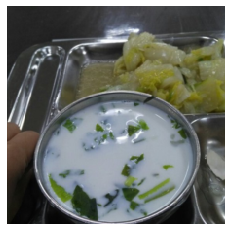

-----------------------------------------
73022_20190401_LUNCH
['米饭', '猪血', '猪肝', '猪肉(瘦)', '油麦菜', '黑木耳（炒）（按拳）']


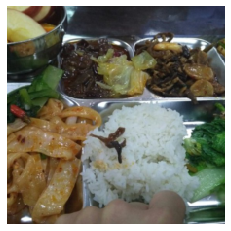

-----------------------------------------
73022_20190402_BREAKFAST
['油麦菜', '牛肉(瘦)', '纯牛奶', '包子(猪肉馅)', '鸡蛋']


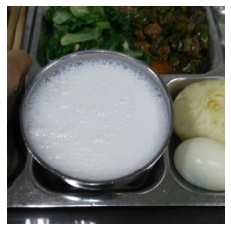

-----------------------------------------
73022_20190402_DINNER
['素炒青菜（上海青）（按拳）', '猪蹄', '猪肝(卤煮)', '藕']


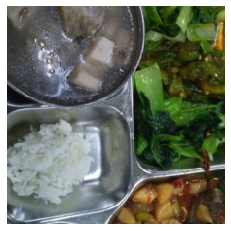

-----------------------------------------
73022_20190402_LUNCH
['菠菜', '大白菜', '刀豆', '青椒', '蒸蛋（鸡蛋羹）（按拳）', '鸡肉', '牛肉(瘦)', '菠萝', '香蕉']


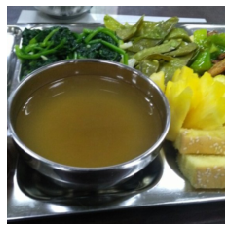

-----------------------------------------
73022_20190403_BREAKFAST
['素炒青菜（上海青）（按拳）', '纯牛奶', '鸡蛋', '包子(猪肉馅)', '豆皮', '杂粮粥']


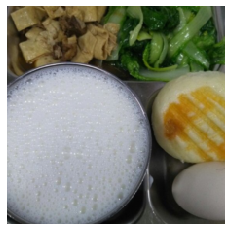

-----------------------------------------
73022_20190403_LUNCH
['凉拌黄瓜（按拳）', '鸡肉', '猪肉(瘦)', '鱼肉', '花菜', '杂粮粥']


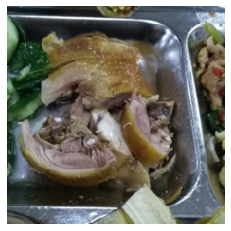

-----------------------------------------
73022_20190404_BREAKFAST
['杂粮粥', '素炒青菜（上海青）（按拳）', '白萝卜', '鸡蛋', '纯牛奶', '包子(猪肉馅)']


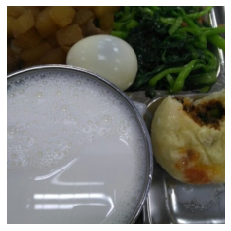

-----------------------------------------
73022_20190404_DINNER
['鱼肉', '鸡蛋', '米饭', '山药']


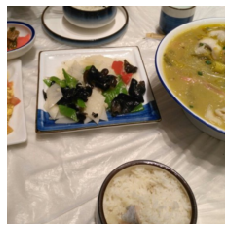

-----------------------------------------
73022_20190404_LUNCH
['鸡肉', '鱼肉', '牛肉(瘦)', '油麦菜', '卷心菜', '茄子（炒）（按拳）', '豆腐干']


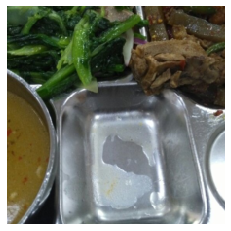

-----------------------------------------


In [9]:
image_dir = "/media/eganlau/meal_pictures/Images/"
ImageFile.LOAD_TRUNCATED_IMAGES = True

for data in dataset[10:20]:
    print(data["id"])
    print(data["ingredients"])
    image_transf = transform(Image.open(image_dir + data['images'][0]).convert('RGB'))
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    print("-----------------------------------------")


In [10]:
print (instrs_vocab_size, ingr_vocab_size)

892 892


In [11]:
ingr_df = pd.DataFrame(ingrs_vocab)
ingr_df.head()

,0
0,<end>
1,鸡蛋
2,米饭
3,纯牛奶
4,番茄


In [12]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
# args.maxseqlen = 15
args.ingrs_only=True
args.image_model='resnet152'
# args.embed_size=80
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join("../saved_models/inversecooking/model/checkpoints", 'model.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = True
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/home/eganlau/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:47: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 4.841503381729126


In [13]:
        transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [14]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [15]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs/fittime')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

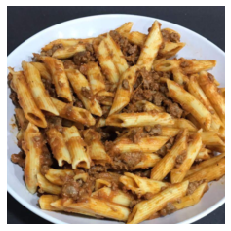

[ 1  5 16 35 13  2 21 40 34  7]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '红薯', '米饭', '大白菜', '香菇(鲜)', '豆腐干', '黄瓜']
[ 1  5 16 35 13  2 21 40 34  7]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '红薯', '米饭', '大白菜', '香菇(鲜)', '豆腐干', '黄瓜']
[ 1  5 16 35 13  2 21 40 34  7]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '红薯', '米饭', '大白菜', '香菇(鲜)', '豆腐干', '黄瓜']
[ 1  5 16 35 13  2 21 40 34  7]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '红薯', '米饭', '大白菜', '香菇(鲜)', '豆腐干', '黄瓜']


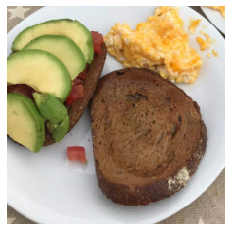

[ 1  2  6  8  4  7 25 12 15 16]
['鸡蛋', '米饭', '玉米（带棒心）', '牛奶', '番茄', '黄瓜', '南瓜', '全麦面包', '胡萝卜', '鸡胸肉']
[ 1  2  6  8  4  7 25 12 15 16]
['鸡蛋', '米饭', '玉米（带棒心）', '牛奶', '番茄', '黄瓜', '南瓜', '全麦面包', '胡萝卜', '鸡胸肉']
[ 1  2  6  8  4  7 25 12 15 16]
['鸡蛋', '米饭', '玉米（带棒心）', '牛奶', '番茄', '黄瓜', '南瓜', '全麦面包', '胡萝卜', '鸡胸肉']
[ 1  2  6  8  4  7 25 12 15 16]
['鸡蛋', '米饭', '玉米（带棒心）', '牛奶', '番茄', '黄瓜', '南瓜', '全麦面包', '胡萝卜', '鸡胸肉']


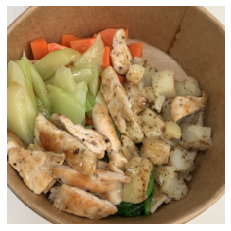

[ 1  5 16 35  4 15  2 13 10 21]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '番茄', '胡萝卜', '米饭', '红薯', '蒸红薯', '大白菜']
[ 1  5 16 35  4 15  2 13 10 21]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '番茄', '胡萝卜', '米饭', '红薯', '蒸红薯', '大白菜']
[ 1  5 16 35  4 15  2 13 10 21]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '番茄', '胡萝卜', '米饭', '红薯', '蒸红薯', '大白菜']
[ 1  5 16 35  4 15  2 13 10 21]
['鸡蛋', '猪肉(瘦)', '鸡胸肉', '意大利面', '番茄', '胡萝卜', '米饭', '红薯', '蒸红薯', '大白菜']


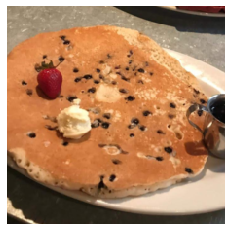

[ 1  8 12  3 17  4  7 44  9 56]
['鸡蛋', '牛奶', '全麦面包', '纯牛奶', '樱桃番茄（圣女果）', '番茄', '黄瓜', '全麦吐司', '鸡蛋(煮)', '鲜牛奶']
[ 1  8 12  3 17  4  7 44  9 56]
['鸡蛋', '牛奶', '全麦面包', '纯牛奶', '樱桃番茄（圣女果）', '番茄', '黄瓜', '全麦吐司', '鸡蛋(煮)', '鲜牛奶']
[ 1  8 12  3 17  4  7 44  9 56]
['鸡蛋', '牛奶', '全麦面包', '纯牛奶', '樱桃番茄（圣女果）', '番茄', '黄瓜', '全麦吐司', '鸡蛋(煮)', '鲜牛奶']
[ 1  8 12  3 17  4  7 44  9 56]
['鸡蛋', '牛奶', '全麦面包', '纯牛奶', '樱桃番茄（圣女果）', '番茄', '黄瓜', '全麦吐司', '鸡蛋(煮)', '鲜牛奶']


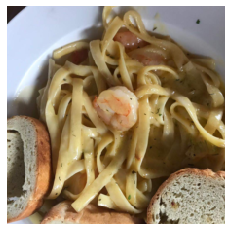

[ 1  5 13 35  2  4 16 10 18 11]
['鸡蛋', '猪肉(瘦)', '红薯', '意大利面', '米饭', '番茄', '鸡胸肉', '蒸红薯', '青菜', '牛肉(瘦)']
[ 1  5 13 35  2  4 16 10 18 11]
['鸡蛋', '猪肉(瘦)', '红薯', '意大利面', '米饭', '番茄', '鸡胸肉', '蒸红薯', '青菜', '牛肉(瘦)']
[ 1  5 13 35  2  4 16 10 18 11]
['鸡蛋', '猪肉(瘦)', '红薯', '意大利面', '米饭', '番茄', '鸡胸肉', '蒸红薯', '青菜', '牛肉(瘦)']
[ 1  5 13 35  2  4 16 10 18 11]
['鸡蛋', '猪肉(瘦)', '红薯', '意大利面', '米饭', '番茄', '鸡胸肉', '蒸红薯', '青菜', '牛肉(瘦)']


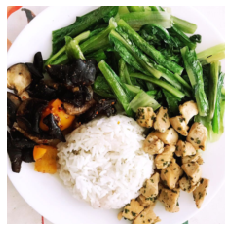

[ 5  2 11  1 13 18 31 16 30 10]
['猪肉(瘦)', '米饭', '牛肉(瘦)', '鸡蛋', '红薯', '青菜', '菠菜', '鸡胸肉', '木耳(水发)', '蒸红薯']
[ 5  2 11  1 13 18 31 16 30 10]
['猪肉(瘦)', '米饭', '牛肉(瘦)', '鸡蛋', '红薯', '青菜', '菠菜', '鸡胸肉', '木耳(水发)', '蒸红薯']
[ 5  2 11  1 13 18 31 16 30 10]
['猪肉(瘦)', '米饭', '牛肉(瘦)', '鸡蛋', '红薯', '青菜', '菠菜', '鸡胸肉', '木耳(水发)', '蒸红薯']
[ 5  2 11  1 13 18 31 16 30 10]
['猪肉(瘦)', '米饭', '牛肉(瘦)', '鸡蛋', '红薯', '青菜', '菠菜', '鸡胸肉', '木耳(水发)', '蒸红薯']


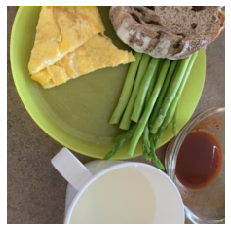

[ 1  8  3  7  9 19 15  4 10 12]
['鸡蛋', '牛奶', '纯牛奶', '黄瓜', '鸡蛋(煮)', '小米粥', '胡萝卜', '番茄', '蒸红薯', '全麦面包']
[ 1  8  3  7  9 19 15  4 10 12]
['鸡蛋', '牛奶', '纯牛奶', '黄瓜', '鸡蛋(煮)', '小米粥', '胡萝卜', '番茄', '蒸红薯', '全麦面包']
[ 1  8  3  7  9 19 15  4 10 12]
['鸡蛋', '牛奶', '纯牛奶', '黄瓜', '鸡蛋(煮)', '小米粥', '胡萝卜', '番茄', '蒸红薯', '全麦面包']
[ 1  8  3  7  9 19 15  4 10 12]
['鸡蛋', '牛奶', '纯牛奶', '黄瓜', '鸡蛋(煮)', '小米粥', '胡萝卜', '番茄', '蒸红薯', '全麦面包']


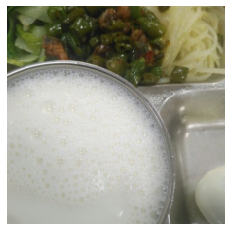

[ 1  3  8 12 13  7 19 52  9 22]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '红薯', '黄瓜', '小米粥', '燕麦麸', '鸡蛋(煮)', '杂粮粥']
[ 1  3  8 12 13  7 19 52  9 22]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '红薯', '黄瓜', '小米粥', '燕麦麸', '鸡蛋(煮)', '杂粮粥']
[ 1  3  8 12 13  7 19 52  9 22]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '红薯', '黄瓜', '小米粥', '燕麦麸', '鸡蛋(煮)', '杂粮粥']
[ 1  3  8 12 13  7 19 52  9 22]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '红薯', '黄瓜', '小米粥', '燕麦麸', '鸡蛋(煮)', '杂粮粥']


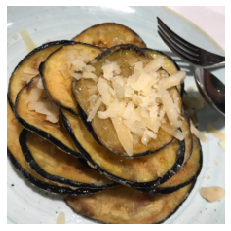

[ 1  2 35  4 16  5 15 13 25 10]
['鸡蛋', '米饭', '意大利面', '番茄', '鸡胸肉', '猪肉(瘦)', '胡萝卜', '红薯', '南瓜', '蒸红薯']
[ 1  2 35  4 16  5 15 13 25 10]
['鸡蛋', '米饭', '意大利面', '番茄', '鸡胸肉', '猪肉(瘦)', '胡萝卜', '红薯', '南瓜', '蒸红薯']
[ 1  2 35  4 16  5 15 13 25 10]
['鸡蛋', '米饭', '意大利面', '番茄', '鸡胸肉', '猪肉(瘦)', '胡萝卜', '红薯', '南瓜', '蒸红薯']
[ 1  2 35  4 16  5 15 13 25 10]
['鸡蛋', '米饭', '意大利面', '番茄', '鸡胸肉', '猪肉(瘦)', '胡萝卜', '红薯', '南瓜', '蒸红薯']


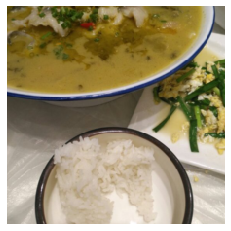

[  2 744   1 205   5  59 209  11  19  43]
['米饭', '西洋菜', '鸡蛋', '豌豆苗', '猪肉(瘦)', '糙米饭', '糙米(未蒸)', '牛肉(瘦)', '小米粥', '小白菜']
[  2 744   1 205   5  59 209  11  19  43]
['米饭', '西洋菜', '鸡蛋', '豌豆苗', '猪肉(瘦)', '糙米饭', '糙米(未蒸)', '牛肉(瘦)', '小米粥', '小白菜']
[  2 744   1 205   5  59 209  11  19  43]
['米饭', '西洋菜', '鸡蛋', '豌豆苗', '猪肉(瘦)', '糙米饭', '糙米(未蒸)', '牛肉(瘦)', '小米粥', '小白菜']
[  2 744   1 205   5  59 209  11  19  43]
['米饭', '西洋菜', '鸡蛋', '豌豆苗', '猪肉(瘦)', '糙米饭', '糙米(未蒸)', '牛肉(瘦)', '小米粥', '小白菜']


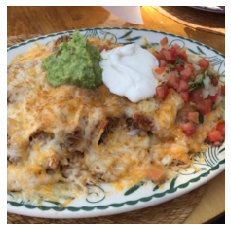

[ 1 12  4 35  5 13 16 10 15  7]
['鸡蛋', '全麦面包', '番茄', '意大利面', '猪肉(瘦)', '红薯', '鸡胸肉', '蒸红薯', '胡萝卜', '黄瓜']
[ 1 12  4 35  5 13 16 10 15  7]
['鸡蛋', '全麦面包', '番茄', '意大利面', '猪肉(瘦)', '红薯', '鸡胸肉', '蒸红薯', '胡萝卜', '黄瓜']
[ 1 12  4 35  5 13 16 10 15  7]
['鸡蛋', '全麦面包', '番茄', '意大利面', '猪肉(瘦)', '红薯', '鸡胸肉', '蒸红薯', '胡萝卜', '黄瓜']
[ 1 12  4 35  5 13 16 10 15  7]
['鸡蛋', '全麦面包', '番茄', '意大利面', '猪肉(瘦)', '红薯', '鸡胸肉', '蒸红薯', '胡萝卜', '黄瓜']


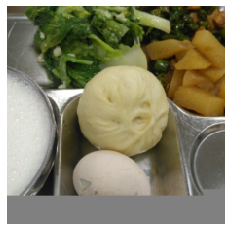

[ 1  3  8 12  7  4 13  9 27  6]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '黄瓜', '番茄', '红薯', '鸡蛋(煮)', '西兰花', '玉米（带棒心）']
[ 1  3  8 12  7  4 13  9 27  6]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '黄瓜', '番茄', '红薯', '鸡蛋(煮)', '西兰花', '玉米（带棒心）']
[ 1  3  8 12  7  4 13  9 27  6]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '黄瓜', '番茄', '红薯', '鸡蛋(煮)', '西兰花', '玉米（带棒心）']
[ 1  3  8 12  7  4 13  9 27  6]
['鸡蛋', '纯牛奶', '牛奶', '全麦面包', '黄瓜', '番茄', '红薯', '鸡蛋(煮)', '西兰花', '玉米（带棒心）']


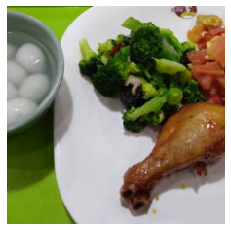

[ 1  3  6  8  7 27  9 18  5 12]
['鸡蛋', '纯牛奶', '玉米（带棒心）', '牛奶', '黄瓜', '西兰花', '鸡蛋(煮)', '青菜', '猪肉(瘦)', '全麦面包']
[ 1  3  6  8  7 27  9 18  5 12]
['鸡蛋', '纯牛奶', '玉米（带棒心）', '牛奶', '黄瓜', '西兰花', '鸡蛋(煮)', '青菜', '猪肉(瘦)', '全麦面包']
[ 1  3  6  8  7 27  9 18  5 12]
['鸡蛋', '纯牛奶', '玉米（带棒心）', '牛奶', '黄瓜', '西兰花', '鸡蛋(煮)', '青菜', '猪肉(瘦)', '全麦面包']
[ 1  3  6  8  7 27  9 18  5 12]
['鸡蛋', '纯牛奶', '玉米（带棒心）', '牛奶', '黄瓜', '西兰花', '鸡蛋(煮)', '青菜', '猪肉(瘦)', '全麦面包']


In [16]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        print(ingr_ids[0])
        print(get_ingrs(ingr_ids[0], ingrs_vocab))